# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [5]:
!ls

categories.csv			   messages.csv
DisasterResponse.db		   ML Pipeline Preparation.ipynb
ETL Pipeline Preparation.ipynb	   ML Pipeline Preparation-zh.ipynb
ETL Pipeline Preparation-zh.ipynb  Twitter-sentiment-self-drive-DFE.csv
InsertDatabaseName.db		   Untitled.ipynb


In [63]:
import sklearn

if float(sklearn.__version__[:4]) < 0.20 : 
    print("PLEASE RESTART NOTEBOOK AFTER THIS INSTALLATION")
    !pip install scikit_learn -U
    

import sklearn
print(sklearn.__version__)

0.24.1


In [150]:
# import libraries

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pprint

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

try:
    from sklearn.model_selection import GridSearchCV
except : 
    print("old version sklearn detected..")
    from sklearn.grid_search import GridSearchCV


from sqlalchemy import create_engine

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.corpus import stopwords

nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [136]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')

df = pd.read_sql_table(table_name="InsertTableName", con=engine)

X = df["message"]
y = df.drop(columns=["id", "message", "original", "genre"], axis=1)

# drop the one category without any occurrences
y.drop(columns=["child_alone"], inplace = True)

X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

### 2. Write a tokenization function to process your text data

In [137]:
def tokenize(text):

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # replace all urls with a placeholder text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "urlplaceholder", text)
    
    # remove numbers
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
   
    stop_words = stopwords.words("english")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    
    # lemmatize and remove stop words
    clean_tokens = []
    for tok in tokens:
        if tok not in stop_words :
            clean_tok = lemmatizer.lemmatize(tok).strip() 
            clean_tokens.append(clean_tok)
    
    return clean_tokens    

In [138]:
# df = X.to_frame()
# df["len"] = df["message"].str.len()

# df.dropna(inplace=True)

# df.head()

In [68]:
# df.describe()

In [139]:
# sns.distplot(df["len"], bins=1000)

# plt.xlim(0,1000)

# df.shape

In [140]:
import string



def clean_text(text) :
    
    text = text.replace("\n", " ").replace("\r", " ")
    
    # replace punctuation with spaces
    t = str.maketrans(' ', ' ', string.punctuation)
    text = text.translate(t)
    
    # replace single auote with empty char
    t = str.maketrans(dict.fromkeys("'`", ""))
    text = text.translate(t)
    
    # replace all urls with a placeholder text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "urlplaceholder", text)
    
    return text


def reg_tokenize(text):     
    
    text = clean_text(text)

    # break into list of words
    WORD = re.compile(r'\w+')    
    words = WORD.findall(text)
    
    #pass through lemmatizer or stemmer
    stop_words = stopwords.words("english")

    lemmatizer = WordNetLemmatizer()
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    clean_tokens = []
    for tok in words :
        if tok not in stop_words :
#             clean_tok = lemmatizer.lemmatize(tok)
#             clean_tok = porter.stem(tok)
            clean_tok = lancaster.stem(tok)
            clean_tokens.append(clean_tok)
    
    return clean_tokens

In [141]:
#benchmarking tokenizer
import time

messages = list(X)

for num_messages in [10, 100, 1000, 10000]:
    
    t1 = time.time()
    
    toks = []
    [toks.append(tokenize(n)) for n in messages[:num_messages]]
    
    t2 = time.time()
    
    print('num messages = ', num_messages, ", time = %.3f"%(t2-t1))
    

all_toks = [item for sublist in toks for item in sublist] 
print(len(all_toks))
print("unique", len(set(all_toks)))

num messages =  10 , time = 0.014
num messages =  100 , time = 0.058
num messages =  1000 , time = 0.602
num messages =  10000 , time = 5.665
81900
unique 9133


In [143]:
#benchmarking reg_tokenize
import time

messages = list(X)

for num_messages in [10, 100, 1000, 10000]:
    
    t1 = time.time()
    
    toks = []
    [toks.append(reg_tokenize(n)) for n in messages[:num_messages]]
    
    t2 = time.time()
    print('num messages = ', num_messages, ", time = %.3f"%(t2-t1))
    
all_toks = [item for sublist in toks for item in sublist]

print(len(all_toks))
print("unique", len(set(all_toks)))

num messages =  10 , time = 0.013
num messages =  100 , time = 0.075
num messages =  1000 , time = 0.743
num messages =  10000 , time = 6.503
98276
unique 8195


### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [144]:
# need to add the filtering of the "message" column only here I guess ...

# pipe = Pipeline([
#     ('features', FeatureUnion([
#         ('text_pipeline', Pipeline([
#             ('col', ColumnSelector(col="message")),
#             ('vect', CountVectorizer(tokenizer=tokenize)),
#             ('tdidf', TfidfTransformer()),
#         ])),
# #         ('starting_verb', StartingVerbExtractor())
#     ])),
#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
# ])

pipe = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('vect', CountVectorizer(tokenizer=reg_tokenize)),
    ('vect_tdidf', TfidfVectorizer(tokenizer=reg_tokenize)),
#     ('tdidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=0)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [145]:
# split and fit data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [146]:
%%time
pipe.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 969 ms, total: 1min 22s
Wall time: 1min 29s


Pipeline(steps=[('vect_tdidf',
                 TfidfVectorizer(tokenizer=<function reg_tokenize at 0x7f518281f950>)),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                                        n_jobs=-1)))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [148]:
# predict on test data
def evaluate(model, X_test, y_test):
    """Predicts and prints scores of model.
    """
    
    cols = y_test.columns
    y_pred = model.predict(X_test)
    
    print('Accuracy = %.3f' % accuracy_score(y_test, y_pred))

    
    report = classification_report(y_test, y_pred, target_names=cols,)
    print(report)
    
    if float(sklearn.__version__[:4]) >= 0.20 :
        
        output_dict = classification_report(y_test, y_pred, target_names=cols, output_dict=True)
        df = pd.DataFrame.from_dict(output_dict, orient="index")
        
        # plot        
        plt.figure(figsize=(6,10))
        sns.barplot(df["f1-score"].sort_values(), df["f1-score"].sort_values().index)
        
        return df
    
    else :
        
        print("sklearn version is old.")
        output = pd.Series()
        
        for i, c in enumerate(cols) : 
            score = f1_score(y_test[c], y_pred.transpose()[i]) 
            output[c] = score
        return output

Accuracy = 0.255
                        precision    recall  f1-score   support

               related       0.85      0.92      0.88      5032
               request       0.81      0.42      0.55      1118
                 offer       0.00      0.00      0.00        36
           aid_related       0.75      0.57      0.65      2688
          medical_help       0.55      0.08      0.14       542
      medical_products       0.70      0.07      0.12       320
     search_and_rescue       0.64      0.10      0.18       174
              security       0.50      0.01      0.02       114
              military       0.69      0.05      0.10       211
                 water       0.84      0.35      0.49       401
                  food       0.84      0.45      0.59       775
               shelter       0.80      0.36      0.50       568
              clothing       0.70      0.12      0.20       118
                 money       0.80      0.03      0.06       130
        missing_people

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1

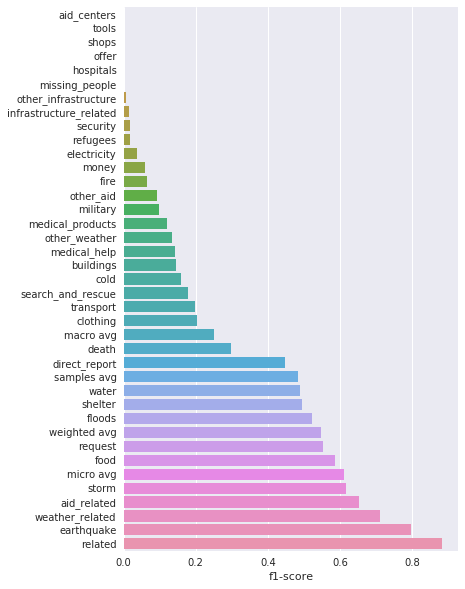

In [149]:
score_df = evaluate(pipe, X_test, y_test)

### 6. Improve your model
Use grid search to find better parameters. 

In [122]:
pprint.pprint(pipe.get_params(), indent=2)

{ 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=10,
                                                       n_jobs=-1, verbose=1)),
  'clf__estimator': RandomForestClassifier(n_estimators=10, n_jobs=-1, verbose=1),
  'clf__estimator__bootstrap': True,
  'clf__estimator__ccp_alpha': 0.0,
  'clf__estimator__class_weight': None,
  'clf__estimator__criterion': 'gini',
  'clf__estimator__max_depth': None,
  'clf__estimator__max_features': 'auto',
  'clf__estimator__max_leaf_nodes': None,
  'clf__estimator__max_samples': None,
  'clf__estimator__min_impurity_decrease': 0.0,
  'clf__estimator__min_impurity_split': None,
  'clf__estimator__min_samples_leaf': 1,
  'clf__estimator__min_samples_split': 2,
  'clf__estimator__min_weight_fraction_leaf': 0.0,
  'clf__estimator__n_estimators': 10,
  'clf__estimator__n_jobs': -1,
  'clf__estimator__oob_score': False,
  'clf__estimator__random_state': None,
  'clf__estimator__verbose': 1,
  'clf__estimator__warm_start': False

In [112]:
%%time

parameters = {
#     'vect__ngram_range': ((1, 1), (1, 2)),
#     'vect__max_df': (0.5, 0.75, 1.0),
#     'vect__max_features': (None, 5000, 10000),
     "clf__estimator__n_estimators" : (10,20),
}

# We define 3 cross validation folds.
# In principle the more the better, but it takes more time too.

cv = GridSearchCV(pipe, param_grid=parameters, verbose=10, cv = 3)

cv.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3; 1/2] START clf__estimator__n_estimators=10.............................


KeyboardInterrupt: 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [92]:
cv.best_params_

{'clf__estimator__n_estimators': 20}

In [113]:
score_df = evaluate(cv, X_test, y_test, cv.classes_)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [124]:
!pip install xgboost

    100% |████████████████████████████████| 788kB 8.9MB/s eta 0:00:01  6% |██                              | 51kB 5.7MB/s eta 0:00:01
  Running setup.py bdist_wheel for xgboost ... error
  Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-o_ixg308/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-j194c3o2 --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.6
  creating build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/dask.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/training.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/sklearn.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/__init__.py -> build/lib.linux-x86_64-3.6/xgboost
  copying xgboost/libpath.py -> build/lib.linux-x86_64-3.6/

Failed to build xgboost
  Running setup.py install for xgboost ... error
    Complete output from command /opt/conda/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-o_ixg308/xgboost/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-dza9u9ul/install-record.txt --single-version-externally-managed --compile:
    running install
    running build
    running build_py
    creating build
    creating build/lib.linux-x86_64-3.6
    creating build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/dask.py -> build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/training.py -> build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/sklearn.py -> build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/__init__.py -> build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/libpath.py -> build/lib.linux-x86_64-3.6/xgboost
    copying xgboost/data.py -> build

    INFO:XGBoost build_ext:Run CMake command: ['cmake', 'xgboost', '-GNinja', '-DUSE_OPENMP=1', '-DUSE_CUDA=0', '-DUSE_NCCL=0', '-DBUILD_WITH_SHARED_NCCL=0', '-DHIDE_CXX_SYMBOLS=1', '-DUSE_HDFS=0', '-DUSE_AZURE=0', '-DUSE_S3=0', '-DPLUGIN_LZ4=0', '-DPLUGIN_DENSE_PARSER=0', '-DUSE_SYSTEM_LIBXGBOOST=0']
    CMake Error at CMakeLists.txt:1 (cmake_minimum_required):
      CMake 3.13 or higher is required.  You are running version 3.5.1
    
    
    -- Configuring incomplete, errors occurred!
    INFO:XGBoost build_ext:Run CMake command: ['cmake', 'xgboost', '-GNinja', '-DUSE_OPENMP=1', '-DUSE_CUDA=0', '-DUSE_NCCL=0', '-DBUILD_WITH_SHARED_NCCL=0', '-DHIDE_CXX_SYMBOLS=1', '-DUSE_HDFS=0', '-DUSE_AZURE=0', '-DUSE_S3=0', '-DPLUGIN_LZ4=0', '-DPLUGIN_DENSE_PARSER=0', '-DUSE_SYSTEM_LIBXGBOOST=0']
    CMake Error at CMakeLists.txt:1 (cmake_minimum_required):
      CMake 3.13 or higher is required.  You are running version 3.5.1
    
    
    -- Configuring incomplete, errors occurred!
    Tracebac

In [125]:
from xgboost import XGBClassifier

# subsample controls the ratio of the randomly selected training samples before growing the tree.
# It ranges between 0 and 1. Higher values tend to cause overfitting. 
# colsample_bytree denotes the fraction of columns 
# to be randomly sampled for each tree.
# n_estimators controls the number of trees to be constructed
# during the classification process. We will optimize that parameter.


xgbclf = XGBClassifier(
    n_estimators=10, 
    n_jobs=-1, 
    verbose=1,
    random_state=42,
    seed=2,
    colsample_bytree=0.6,
    subsample=0.7
)

pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=reg_tokenize)),
    ('tdidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(xgbclf))
])

ModuleNotFoundError: No module named 'xgboost'

In [4]:
using this ? 


clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

NameError: name 'X_train' is not defined

### 9. Export your model as a pickle file

In [ ]:
pickle.dump(model, open( model_filepath, "wb" ))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.